<a href="https://colab.research.google.com/github/VolkhinD/santiment_analysis/blob/main/quick_with_hugging_face_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
%%capture
! pip install transformers

In [18]:
import warnings
warnings.filterwarnings('ignore')
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
df = pd.read_csv("/content/drive/MyDrive/Data/sentiment_analysis/big_reviews.csv", usecols=[4, 3])
df = df.rename(columns={'content': 'comment'})

In [20]:
def to_sentiment(row):
  if row <= 2:
    return 0
  elif row == 3:
    return 1
  else:
    return 2
df.score = df.score.apply(to_sentiment)
class_names = df.score.unique()

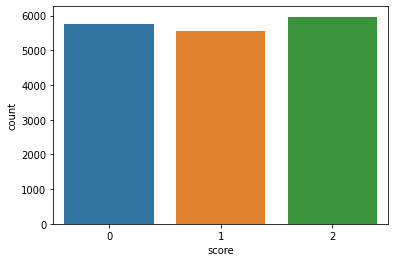

In [21]:
sns.countplot(df.score)

In [22]:
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
cls = pipeline('sentiment-analysis', model=model_name, tokenizer=tokenizer)


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weight

# Dataset, Dataloaders

In [23]:
class ClsData(Dataset):
  def __init__(self, df):
    self.df = df
    self.text = df.comment.to_numpy()
    self.label = df.score.to_numpy()
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    ans = tokenizer.encode_plus(self.text[index], padding=True, return_tensors='pt', truncation=True)
    return {
        'input_ids': ans['input_ids'].flatten(),
        'attention_mask': ans['attention_mask'].flatten(),
        'label': torch.tensor(self.label[index], dtype=torch.long)
    }



 I use **Dynamic padding** so each bath has it's own max lenngth, the length of longest sentence in a batch. To do that I remove 'sentence' key from Dataset dict beacause it doesn't work with text

In [24]:
data_collator = DataCollatorWithPadding(tokenizer)
train_valid, test = train_test_split(df, test_size=0.2, random_state=42)
train, valid = train_test_split(train_valid, test_size=0.25, random_state=42)
data = {'train': train, 'valid': valid, 'test': test}
data_len = {key: len(data[key]) for key in ['train', 'valid', 'test']}
ds_data = {key: ClsData(data[key]) for key in ['train', 'valid', 'test']}
dataloaders = {key: DataLoader(ds_data[key], batch_size=8, collate_fn=data_collator) for key in ['train', 'valid', 'test']}

In [25]:
for step, batch in enumerate(dataloaders['train']):
    print(batch["input_ids"].shape)
    if step > 5:
        break

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.Size([8, 117])
torch.Size([8, 116])
torch.Size([8, 106])
torch.Size([8, 113])
torch.Size([8, 55])
torch.Size([8, 116])
torch.Size([8, 103])


# Training

## Hugging face API

In [26]:
training_args = TrainingArguments("test-trainer")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [27]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=ds_data["train"],
    eval_dataset=ds_data["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,

)

We didn’t tell the Trainer to evaluate during training by setting evaluation_strategy to either "steps" (evaluate every eval_steps) or "epoch" (evaluate at the end of each epoch).
We didn’t provide the Trainer with a compute_metrics() function to calculate a metric during said evaluation (otherwise the evaluation would just have printed the loss, which is not a very intuitive number).

In [28]:
trainer.train()

***** Running training *****
  Num examples = 10361
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3888


Step,Training Loss
500,0.849100
1000,0.746300
1500,0.665900
2000,0.544900
2500,0.515200
3000,0.383600
3500,0.331100


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1500
Configuration saved in test-trainer/checkpoint-1500/config.json
Model weights saved in test-trainer/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1500/tokenizer_config.json
Special tokens file saved

TrainOutput(global_step=3888, training_loss=0.5505083578604238, metrics={'train_runtime': 841.1672, 'train_samples_per_second': 36.952, 'train_steps_per_second': 4.622, 'total_flos': 1885686586664328.0, 'train_loss': 0.5505083578604238, 'epoch': 3.0})

In [29]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Models/sentiment_bert.pt")

In [30]:
predictions = trainer.predict(ds_data["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)
preds = np.argmax(predictions.predictions, axis=-1)
preds

***** Running Prediction *****
  Num examples = 3454
  Batch size = 8


(3454, 3) (3454,)


array([0, 0, 1, ..., 0, 2, 1])

In [31]:
print(classification_report(test.score, preds))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1160
           1       0.66      0.69      0.68      1114
           2       0.85      0.80      0.82      1180

    accuracy                           0.76      3454
   macro avg       0.77      0.76      0.76      3454
weighted avg       0.77      0.76      0.77      3454

